<a href="https://colab.research.google.com/github/yongan007/advanced-computer-vision/blob/main/YongAnn_ACV_HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

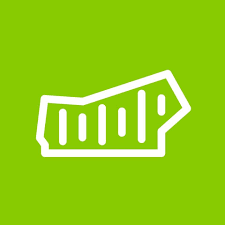

# Advanced Computer Vision
## Innopolis University 
## BEKKOUCH Imad Eddine Ibrahim
### Week 1-2 : Classification & Interpretable AI
1. Build a classifier from scratch
2. Build a classifier from a pretrained model
3. Evaluate the two classifiers on their mistakes


Student: Yong Ann Voeurn

# 1. Build a classifier from scratch 
Graded part: 
1. Read the dataset 
2. Make simple transfors using the albumentations library
3. Build the model and the flow function (forward)
4. Train the model
5. Evaluate the model on accuracy

Let's install the library, please run this code twice after restarting the runtime.

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 37.6MB 77kB/s 
     |████████████████████████████████| 952kB 40.6MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

Download the dataset from here 
https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset

In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

dataset_directory = os.path.join(os.environ["HOME"], "datasets/cats-vs-dogs")

filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

kagglecatsanddogs_3367a.zip: 100%|██████████| 787M/787M [00:06<00:00, 136MB/s]


In [ ]:
root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4936 10


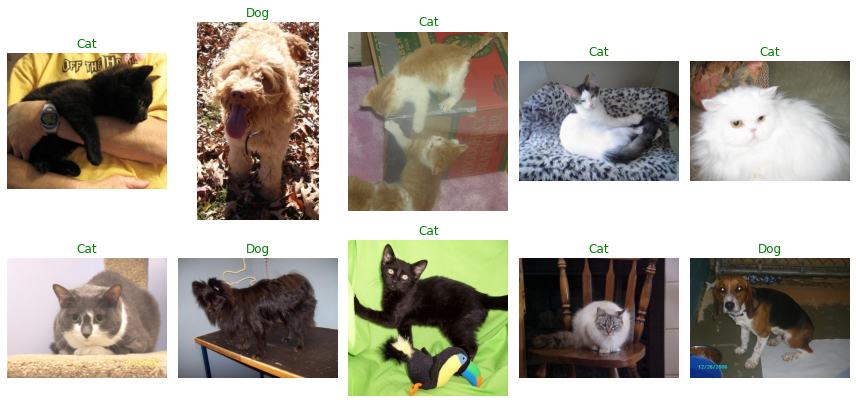

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

## CODE 1 ###TODO 

In [ ]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths) # TODO return the length of the dataset

    def __getitem__(self, idx):
        # TODO read the image and guess the label from the path and return image and label
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

## CODE 2 TODO

In [ ]:

train_transform = A.Compose(
    [
        
        # TODO add a variety of transformations from the albumentations library
        # A.RandomCrop(width=256, height=256),
        A.SmallestMaxSize(max_size=160),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [ ]:
img,_=train_dataset[1]
img.shape

torch.Size([3, 128, 128])

In [ ]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),    
     ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

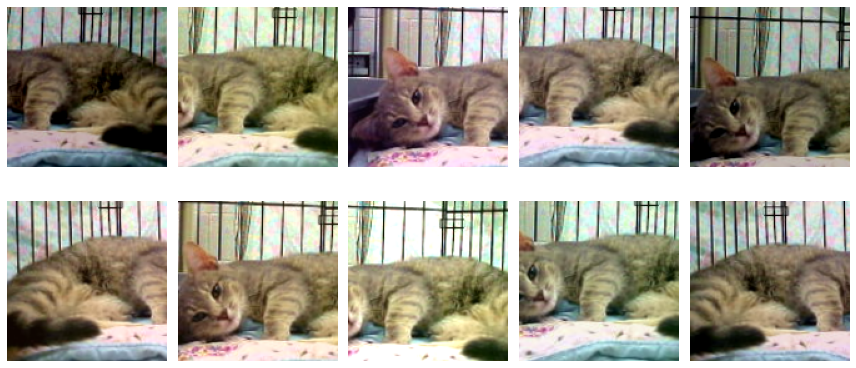

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset)

In [ ]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 10,
}

## CODE 3 TODO

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # todo define the different layers needed. (you can use any filter size number of layers you want)
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # TODO define the flow of the input batch 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
model = net # getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [ ]:

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## CODE 3 todo

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    
    stream = train_loader #tqdm(
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        
        # TODO back propagte the loss 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # stream.set_description
        print(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = val_loader #tqdm(
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # print(type(images))
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            print(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

# CODE 5 TODO 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.vgg19(pretrained=True)# todo add vgg pretrained model and fine tune it
        self.net.trainable = False
        num = self.net.classifier[0].in_features
       
        self.net.classifier = nn.Sequential(nn.Linear(num, 1024),
                                 nn.ReLU(True),
                                 nn.Dropout(p=0.7, inplace=False),
                                 nn.Linear(1024, 100),
                                 nn.Dropout(p=0.2, inplace=False),
                                 nn.ReLU(True),
                                 nn.Linear(100,1))

    def forward(self, x): 
        return self.net(x)


model =  Net().to(params["device"])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 
    10,
}

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1. Train.      Loss: 0.687 | Accuracy: 0.625
Epoch: 1. Train.      Loss: 0.693 | Accuracy: 0.555
Epoch: 1. Train.      Loss: 0.687 | Accuracy: 0.568
Epoch: 1. Train.      Loss: 0.684 | Accuracy: 0.586
Epoch: 1. Train.      Loss: 0.688 | Accuracy: 0.578
Epoch: 1. Train.      Loss: 0.690 | Accuracy: 0.581
Epoch: 1. Train.      Loss: 0.698 | Accuracy: 0.569
Epoch: 1. Train.      Loss: 0.698 | Accuracy: 0.570
Epoch: 1. Train.      Loss: 0.699 | Accuracy: 0.564
Epoch: 1. Train.      Loss: 0.699 | Accuracy: 0.561
Epoch: 1. Train.      Loss: 0.700 | Accuracy: 0.558
Epoch: 1. Train.      Loss: 0.704 | Accuracy: 0.557
Epoch: 1. Train.      Loss: 0.707 | Accuracy: 0.556
Epoch: 1. Train.      Loss: 0.705 | Accuracy: 0.558
Epoch: 1. Train.      Loss: 0.709 | Accuracy: 0.550
Epoch: 1. Train.      Loss: 0.713 | Accuracy: 0.540
Epoch: 1. Train.      Loss: 0.713 | Accuracy: 0.542
Epoch: 1. Train.      Loss: 0.712 | Accuracy: 0.540
Epoch: 1. Train.      Loss: 0.711 | Accuracy: 0.539
Epoch: 1. Tr

Another try 

In [ ]:
model = models.vgg19(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(nn.Linear(25088, 1024),
                                 nn.ReLU(True),
                                 nn.Dropout(p=0.7, inplace=False),
                                 nn.Linear(1024, 100),
                                 nn.Dropout(p=0.2, inplace=False),
                                 nn.ReLU(True),
                                 nn.Linear(100,1))
for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=params["lr"])

In [ ]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 
    5,
}

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1. Train.      Loss: 0.094 | Accuracy: 0.984
Epoch: 1. Train.      Loss: 0.095 | Accuracy: 0.969
Epoch: 1. Train.      Loss: 0.118 | Accuracy: 0.948
Epoch: 1. Train.      Loss: 0.138 | Accuracy: 0.941
Epoch: 1. Train.      Loss: 0.125 | Accuracy: 0.947
Epoch: 1. Train.      Loss: 0.120 | Accuracy: 0.951
Epoch: 1. Train.      Loss: 0.130 | Accuracy: 0.953
Epoch: 1. Train.      Loss: 0.137 | Accuracy: 0.951
Epoch: 1. Train.      Loss: 0.139 | Accuracy: 0.948
Epoch: 1. Train.      Loss: 0.136 | Accuracy: 0.950
Epoch: 1. Train.      Loss: 0.128 | Accuracy: 0.953
Epoch: 1. Train.      Loss: 0.122 | Accuracy: 0.954
Epoch: 1. Train.      Loss: 0.119 | Accuracy: 0.957
Epoch: 1. Train.      Loss: 0.116 | Accuracy: 0.956
Epoch: 1. Train.      Loss: 0.115 | Accuracy: 0.957
Epoch: 1. Train.      Loss: 0.109 | Accuracy: 0.959
Epoch: 1. Train.      Loss: 0.106 | Accuracy: 0.960
Epoch: 1. Train.      Loss: 0.104 | Accuracy: 0.960
Epoch: 1. Train.      Loss: 0.114 | Accuracy: 0.956
Epoch: 1. Tr

# Explain the classifiers prediction on a batch of images Bonus section
Bonus, add vizulisation of the image, the predicted class and cam for multiple images
Bonus choose images where the model makes mistakes 



In [ ]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models
import os
import matplotlib.pyplot as plt
from PIL import Image

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask,i=1):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam"+str(i)+".jpg", np.uint8(255 * cam))


class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        # replace ReLU with GuidedBackpropReLU
        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropReLU.apply

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output




def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)


def display_grad_cam_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = np.float32(cv2.resize(image, (224, 224))) / 255
        input = preprocess_image(img)
        target_index = None
        mask = grad_cam(input, target_index)
        show_cam_on_image(img, mask,i)
        img = get_image('cam'+str(i)+'.jpg')
       
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(img)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


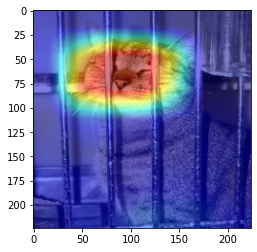

In [ ]:
grad_cam = GradCam(model=models.vgg19(pretrained=True), \
                       target_layer_names=["36"], use_cuda=False)


img = cv2.imread("/root/datasets/cats-vs-dogs/PetImages/Cat/1885.jpg", 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
target_index = None
mask = grad_cam(input, target_index)

show_cam_on_image(img, mask,i=20)

img = get_image('cam20.jpg')
plt.imshow(img)

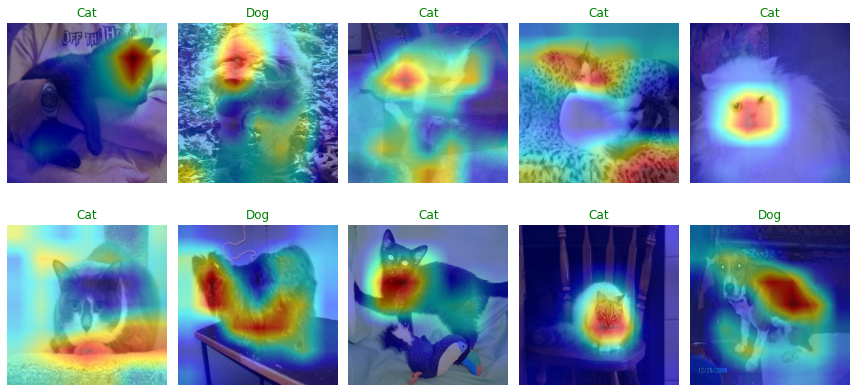

In [ ]:
grad_cam = GradCam(model=models.vgg19(pretrained=True), \
                       target_layer_names=["36"], use_cuda=False)

display_grad_cam_grid(test_images_filepaths)

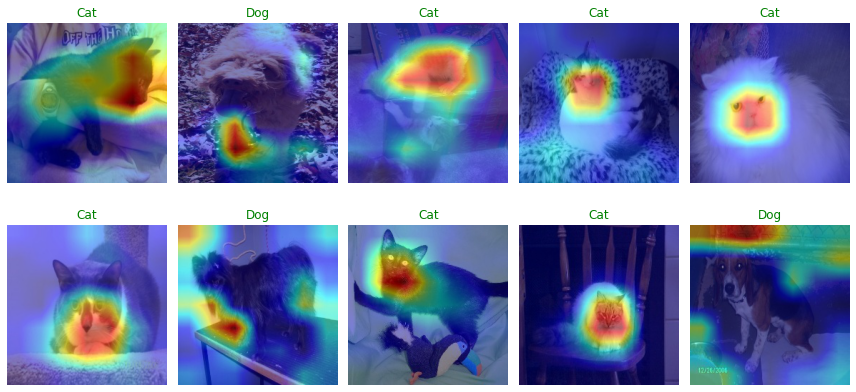

In [ ]:
grad_cam = GradCam(model=model, \
                       target_layer_names=["36"], use_cuda=True)
display_grad_cam_grid(test_images_filepaths)

- The original vgg19 gives wild detection to both cat and dog. 

- Even though the fined tuned vgg19 gives a dramatic accuracy, it is kinda only good at detecting cats not dogs. Luckly, we have only two classes so if it's not a cat then it's a dog.